# Introduction

The Elbow method is a technique to visually determine where the optimal cluster is located. This is based on the assumption that the "elbow" is present at a point on the inertia graph, and from there the contributions made by each following cluster becomes less and less significant, this graph expresses a sort of decreasing exponential curve.

On the other hand, it can be seen that after this point the curve becomes more and more linear, so that if we add more and more clusters, the curve will behave asymptotically (without providing any relevant information).

My technique is based on three fundamental pillars:
  * Interpolation
  * Numerical derivative
  * Distance or "linearity" (a concept I will introduce later) between each calculated derivative.

Using *calculus*, *numerical methods* and *approximation theory* we can obtain very valuable information from a curve, whatever it is. And from this make a more detailed analysis to find patterns, in this study these will be the increases or decreases of the rate of change, or in other words; the derivatives of the interpolated function.
With it we will be able to build a vector or matrix from which to extract the most relevant points where the significant decay of the function occurs and thus calculate the optimal cluster.

Topics to be covered:
 * Generating data with uniform distribution
 * K-Means, MinMax scaler and inertia generator
 * Lagrange interpolation
 * Runge effect
 * First numerical derivative
 * Minimum distance, selecting the optimal cluster
 * Elbow-Lagrange class
 * Elbow-Lagrange in Uniform distribution
 * Elbow-Lagrange in Gaussian distribution
 * Robust Elbow-Lagrange

# Necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# Generating data with a uniform distribution

At first we will use a uniform distribution to select an interval, once the method is completed we will generalize this to use another type of distribution.

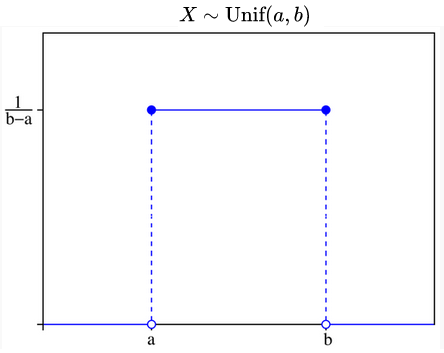

In [ ]:
min_x = 500
max_x = 500
min_y = 500
max_y = 500
samples = 500

x:np.ndarray = np.random.uniform(-min_x, max_x, samples)
y:np.ndarray = np.random.uniform(-min_y, max_y, samples)

df = pd.DataFrame(data={'x':x, 'y':y})
df.head()

,x,y
0,57.479187,359.070309
1,-10.199362,-112.878881
2,185.939569,-354.045139
3,-184.022077,-430.830761
4,-333.667106,174.693318


Lets plot the distribution

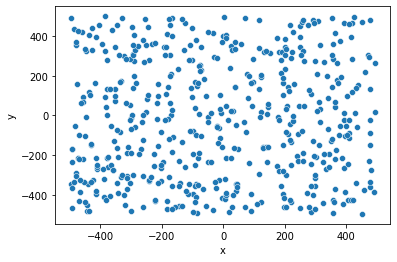

In [ ]:
sns.scatterplot(data=df, x='x', y='y')
plt.show()

# K-Means, MinMax scaler and Inertia generator.

K-means is a clustering method, which aims at partitioning a set of **n** observations into **k** groups, where each observation belongs to the group whose mean value is the closest to the nearest **n**. This algorithm is based on a distance metric (internally a distance matrix is calculated, generally using the Pythagoras formula) and iteratively the problem is solved until the **k**-groups converge to a minimum error or stopping criterion.

In a very brief way this is the function we are looking to optimize:

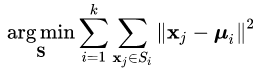

From here, there is a deeper mathematical development, which encompasses optimization and the inclusion of distance metrics that produce changes in the final result of the algorithm, however this is beyond of the scope in this research. It remains for the reader to find out more about this algorithm and the effect of applying it to non-spherical data.

The next step is the inertia generator algorithm in which we can see the behavior of the KMeans for the different clusters selected. [2,b].
Where:
  * 2 represents the minimum
  * b represents the maximum, i recommend a maximum of 15.

**About inertia**

It calculates the squared distance of each sample **Xi** for each existing cluster **Ci**. This process is performed for each of the clusters(and this is repeated for all samples within the data set).

The lower the Inertia value, the lower the squared error of the different clusters. For example, as the number of clusters approaches the sample size the inertia will tend more and more to 0. So when *k=n* then the inertia will be 0.

In [ ]:
def generate_inertia(matrix:np.ndarray, min_clusters:int=2, max_clusters:int=7)->list:
  k_list = list()
  inertia = list()
  
  for k in range(min_clusters, max_clusters+1):
    km = KMeans(n_clusters=k)
    km.fit(matrix)

    k_list.append(k)
    inertia.append(km.inertia_)

  return k_list, inertia

As previously mentioned, KMeans works with distance metrics, so if the data are in different units this will directly affect the performance of the algorithm, the same happens in the case of small atypical data and large atypical data, so it is necessary to normalize the data before working with them.

Let's use the following formula.

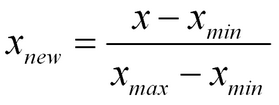

In [ ]:
mmscaler = MinMaxScaler()
normalized_matrix = mmscaler.fit_transform(df[['x', 'y']])
# let's see the first 8 rows
normalized_matrix[:8]

array([[0.55991005, 0.85888904],
       [0.49157207, 0.3852215 ],
       [0.68962209, 0.14317716],
       [0.3160557 , 0.06611197],
       [0.1649526 , 0.67384074],
       [0.19602758, 0.54929904],
       [0.40235213, 0.30328276],
       [0.18396773, 0.12362119]])

Let's apply the algorithm and make the inertia plot

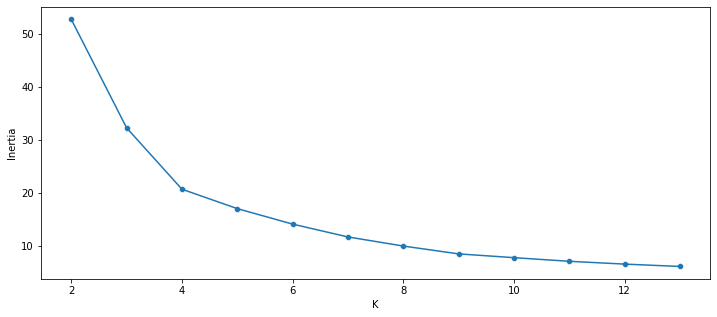

In [ ]:
MIN_CLUSTERS = 2
MAX_CLUSTERS = 13
k, inertia = generate_inertia(normalized_matrix, MIN_CLUSTERS, MAX_CLUSTERS)

plt.subplots(figsize=(12,5))
sns.lineplot(x=k, y=inertia)
sns.scatterplot(x=k, y=inertia)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

Up to this point we did the classical analysis using only the data and the KMeans (regardless of the type generated). In the following we will introduce some concepts of *approximation theory* and *calculus* to obtain the velocity vector and study the behavior of the inertia curve.

# Lagrange Interpolation

Interpolation is a method for constructing new data points based on a (discrete) range of known data points, this is an important topic in *numerical analysis*. And it also has application in a branch of mathematics called *approximation theory*. In this study we will see the Lagrange polynomial interpolator, which is one of the many numerical methods that can be done computationally.

Lagrange's method is very easy to implement in its algorithmic form, and is faster than Newton's interpolation method. Let us look at its mathematical formulation:


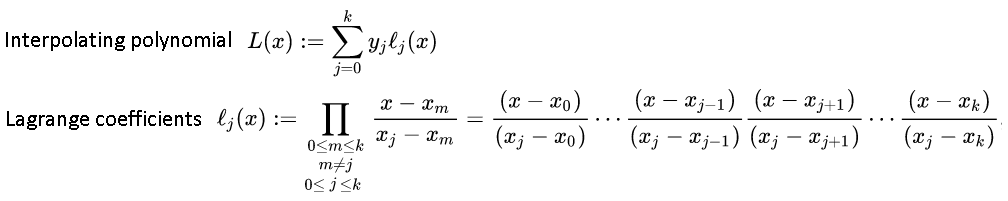


The downside of any interpolation method is that if we want to introduce a new x (in the matrix or vector of data to interpolate) the algorithm will have to recalculate all the points again. Although this is not ideal in applications that work in real time, but in this case we will not encounter any problem...

In [ ]:
class LagrangeInterpolation:
  def __init__(self, x:list, y:list):
    self.__x = x
    self.__y = y
    self.__n = len(x)
  
  def fit_transform(self, x:float):
    lx = 0.0
    for i in range(0, self.__n, 1):
        l_coeff = 1.0
        for j in range(0, self.__n, 1):
            if j != i:
                xj = self.__x[j]
                l_coeff = l_coeff * (x - xj)/(self.__x[i] - xj)
        
        lx += self.__y[i] * l_coeff

    return lx

*applying interpolation*

In [ ]:
lag = LagrangeInterpolation(k, inertia)
y_lag= []
for x in k:
  y_lag.append( lag.fit_transform(x) )

y_lag

[52.75785111707728,
 32.277661864179194,
 20.68986714623271,
 17.026010615620738,
 14.102549710957948,
 11.679487602749456,
 9.959819907030028,
 8.481225871250365,
 7.769389320958634,
 7.083928097040818,
 6.5512880507035325,
 6.110090356478551]

**Interpolation plot vs. KMeans curve plot (without interpolation)**.

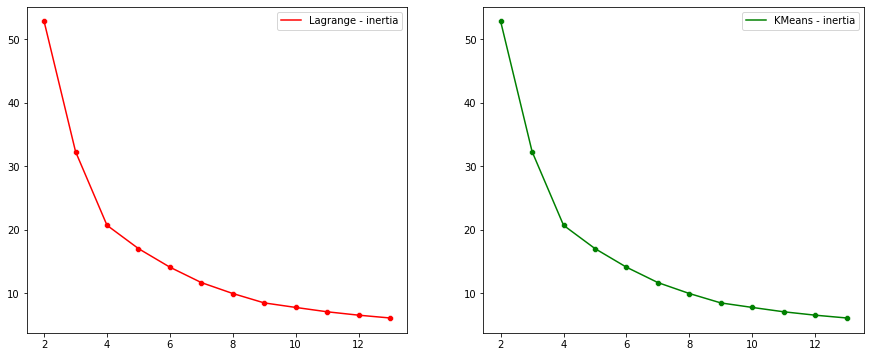

In [ ]:
_, axs = plt.subplots(figsize=(15,6), ncols=2)

k_ = np.arange(MIN_CLUSTERS, len(y_lag) + MIN_CLUSTERS, 1)
sns.lineplot(x=k_, y=y_lag, color='red', ax=axs[0], label='Lagrange - inertia')
sns.scatterplot(x=k_, y=y_lag, color='red', ax=axs[0])

sns.lineplot(x=k, y=inertia, color='green', ax=axs[1], label='KMeans - inertia')
sns.scatterplot(x=k, y=inertia, color='green', ax=axs[1])

plt.show()

In general the result is as expected, both methods coincide. However, due to the stochasticity of the generated data, if the degree of the polynomial is very high (because a larger range of clusters is added), there may be oscillations in the tails of the interpolating curve, so we use an interval of approximately [2, 13].

We are now in a position to obtain certain properties of the curve, but first let's talk briefly about the Runge effect.

# Runge effect

*It is a problem of oscillation at the edges of an interval that occurs when using polynomial interpolation with high degree polynomials on a set of equispaced points.*

This is important in approximation theory because it shows that the high degree of an interpolation does not imply an improvement in the approximation of the curve to be interpolated. Let's see a classical example:

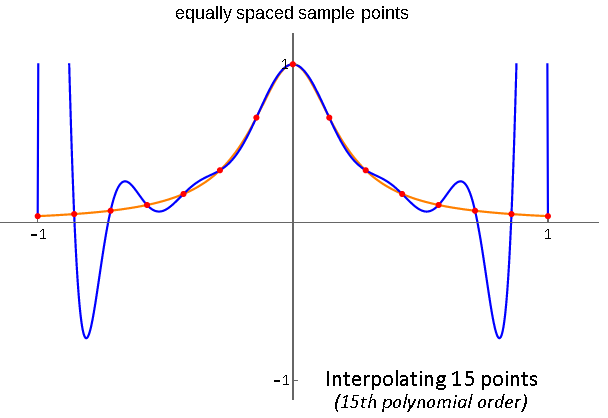

This effect was first discovered when studying the error of interpolations on certain types of functions.

The graph shown above corresponds to the **Runge function**.

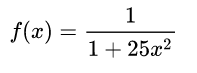

Let us check the Runge effect on our curve,
to do this we will take 3 points outside the given interval a < x < b.

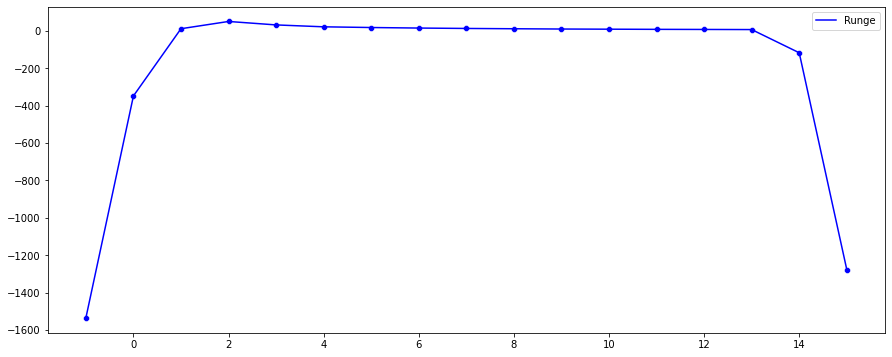

In [ ]:
runge = LagrangeInterpolation(k, inertia)
y_runge= []
x_runge = []
for x in range(MIN_CLUSTERS-3, MAX_CLUSTERS+3):
  x_runge.append(x)
  y_runge.append( runge.fit_transform(x) )
  
plt.subplots(figsize=(15,6))
sns.lineplot(x=x_runge, y=y_runge, color='blue', label='Runge')
sns.scatterplot(x=x_runge, y=y_runge, color='blue')

plt.show()

As we can see, outside our curve the runge effect is present. This is a very important fact when calculating derivatives, it tells us that if we calculate a forward derivative we will necessarily take a point outside the interval, and the consequence will be disastrous... later we will see a way to avoid this.

# First numerical derivative

In numerical analysis we have a method to calculate the derivative using a simple formula, which starts from the mathematical definition of derivative. Although it is very easy to implement it has some shortcomings and impressions which can be worked on to improve.

Some examples of variations of this algorithm are:
  * Forward derivative
  * Backward derivative
  * Central derivative

Which are modifications to the base method (in the case of the central derivative, this offers better accuracy), this also depends on the type of problem we face. If for example we need to obtain the velocity of a comet approaching the earth and we have a sophisticated system that obtains in real time its position at each instant, the traditional derivative would be useless because we would only have the instant t and certainly t-1, t-2, t-3, t-n... in such an example we would use a backward derivative to calculate the velocity vector and make a projection.

However, we are satisfied with the classical definition (this is not a real time problem!), so a more sophisticated method will not bring us any benefit other than accuracy.

Let's look at the mathematical definition:

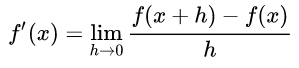

Let's implement this in code

In [ ]:
def dydx(func:object, x:float)->float:
  h:float = 1e-5 # h or dx must be infinitesimal!
  return (func(x+h)-func(x))/h

This code will only work if we pass as argument the function to derive and the point where we want to obtain the slope **m** of the tangent line.

*Since we already have the function (the curve we interpolate using Lagrange) we don't need that parameter. Let's make a modification to the Lagrange code*

In [ ]:
class LagrangeInterpolation:
  def __init__(self, x:list, y:list):
    self.__x = x
    self.__y = y
    self.__n = len(x)
  
  def fit_transform(self, x:float):
    lx = 0.0
    for i in range(0, self.__n, 1):
        l_coeff = 1.0
        for j in range(0, self.__n, 1):
            if j != i:
                xj = self.__x[j]
                l_coeff = l_coeff * (x - xj)/(self.__x[i] - xj)
        
        lx += self.__y[i] * l_coeff
    
    return lx
  
  def dydx(self, x)->float:
    h = 1e-5 # in theory h is an infinitesimal
    return (self.fit_transform(x+h)-self.fit_transform(x))/h

As we see the parameter is passed internally, the f(x+h) will find its value on the interpolated curve and we can calculate the derivative without any problem.

Let us calculate the derivatives for all points of the inertia curve.

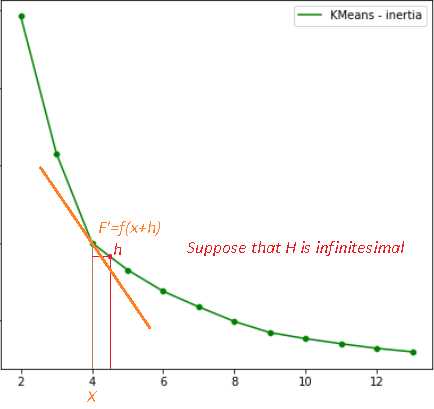

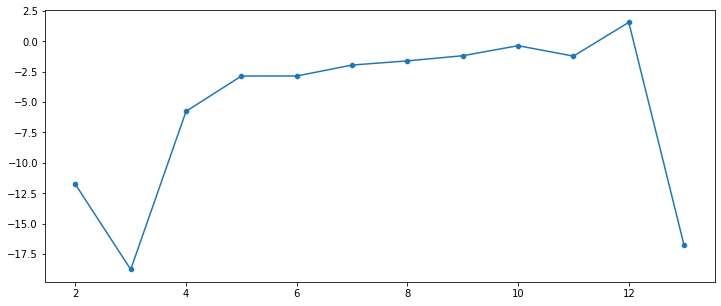

In [ ]:
lag = LagrangeInterpolation(k, inertia)
dydx_= []
for x in k:
  dydx_.append( lag.dydx(x) )

plt.subplots(figsize=(12,5))
sns.lineplot(x=k, y=dydx_)
sns.scatterplot(x=k, y=dydx_)
plt.show()

In the section on the Runge effect we studied the oscillations produced in high degree interpolations, the same happens in this case. The derivative calculated at the last point of the curve may result in an atypical value, since: **f' = f(x+h)**. And although **h** is an infinitesimal value this small sum will be calculated outside the interval, and we already observed the effect of this...

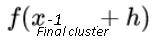

In [ ]:
dydx_

[-11.765518920725524,
 -18.76357805414841,
 -5.761399919279596,
 -2.8600672369094577,
 -2.855413967672859,
 -1.957305310718027,
 -1.6133141794938408,
 -1.1899642521129294,
 -0.36400021672378097,
 -1.2214291398748855,
 1.5544727123284472,
 -16.78879898596719]

To solve this we will simply omit the final x, so we will calculate **N-1** points, in addition we will obtain the absolute values, since for practical purposes we are not interested in the sign.

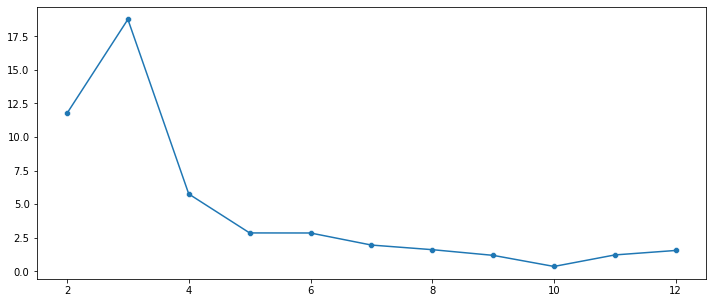

In [ ]:
lag = LagrangeInterpolation(k, inertia)
k_ = k[:-1]
dydx_= []
for x in k_:
  dydx_.append( np.abs(lag.dydx(x)) )

plt.subplots(figsize=(12,5))
sns.lineplot(x=k_, y=dydx_)
sns.scatterplot(x=k_, y=dydx_)
plt.show()

In [ ]:
dydx_

[11.765518920725524,
 18.76357805414841,
 5.761399919279596,
 2.8600672369094577,
 2.855413967672859,
 1.957305310718027,
 1.6133141794938408,
 1.1899642521129294,
 0.36400021672378097,
 1.2214291398748855,
 1.5544727123284472]

As we can see, the problem was partially solved.

# Minimum distance, selecting the optimal cluster

When I first thought of this technique it came to my mind to calculate the distance between derivatives, and since we have the instantaneous velocity at each point of the curve we can know if there is a relative change in each pair of points, then i suppose:
  * If there is NO relative change, the distance will be less than or equal to 1.
  * If there is a relative change the distance will be greater than 1.

When we refer to distance we are talking about a simple count, that is: the difference between the derivative at instant x and x+1. Let's see it with a simple formula:


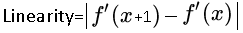

I call this concept linearity, for the simple fact that if there is no real contribution in the velocity or change (between points) there will come a point where the distance will be small enough (or negligible), so that when we approach a value less than 1 we can say that the curve is linear. *Let us always keep in mind that both the derivative and the distance are calculated for f'(x+1) and f'(x). That is, forward.

In my experiment I used 1 as the threshold value, however this can be changed to any other value, preferably small.

Here is a simple algorithm I devised to test this:

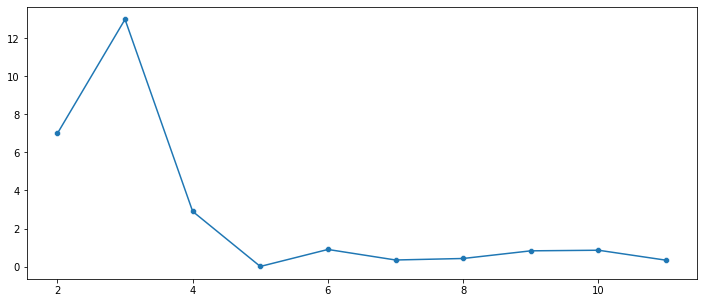

In [ ]:
x_dists= []
y_dists= []

for x in range(0, len(dydx_)-1):
  x_dists.append( x+MIN_CLUSTERS )
  y_dists.append( np.abs(dydx_[x+1]-dydx_[x]) )

plt.subplots(figsize=(12,5))
sns.lineplot(x=x_dists, y=y_dists)
sns.scatterplot(x=x_dists, y=y_dists)
plt.show()

In [ ]:
y_dists

[6.9980591334228865,
 13.002178134868814,
 2.9013326823701386,
 0.0046532692365985895,
 0.8981086569548322,
 0.3439911312241861,
 0.4233499273809114,
 0.8259640353891484,
 0.8574289231511045,
 0.33304357245356164]

Let's make a condition to cut off when it detects the first least significant distance (less than 1).

In [ ]:
# empecemos desde el cluster definido inicial
optimum_k = MIN_CLUSTERS 
for x in range(0, len(dydx_)-1):
  dist = np.abs(dydx_[x+1]-dydx_[x])
  print( dist )
  if dist < 1.0:
    break
  optimum_k += 1

print("\nOptimum k-cluster:{}".format(optimum_k))

6.9980591334228865
13.002178134868814
2.9013326823701386
0.0046532692365985895

Optimum k-cluster:5


Conclusion:

As we can see the method works, we obtained the optimal cluster in this example... Of course, this method can be further improved, since the logic itself is very simple and can fail in certain cases.

This will be discussed in the following sections.

# Elbow-Lagrange class

Putting all the pieces together we will create two classes, one to interpolate and derive, and the other to compute the optimal cluster.

In [ ]:
class LagrangeInterpolation:
  def __init__(self, x:list, y:list):
    self.__x = x
    self.__y = y
    self.__n = len(x)
  
  def fit_transform(self, x:float):
    lx = 0.0
    for i in range(0, self.__n, 1):
        l_coeff = 1.0
        for j in range(0, self.__n, 1):
            if j != i:
                xj = self.__x[j]
                l_coeff = l_coeff * (x - xj)/(self.__x[i] - xj)
        
        lx += self.__y[i] * l_coeff
    
    return lx
  
  def dydx(self, x)->float:
    h = 1e-5 # in theory h is an infinitesimal
    return (self.fit_transform(x+h)-self.fit_transform(x))/h

class ElbowLagrange:
  def __init__(self, normalized_matrix, min_clusters:int=2, max_clusters:int=7)->None:
    self.__MIN_C = min_clusters
    self.__MAX_C = max_clusters
    self.__normalized_matrix = normalized_matrix
    self.__dydx_ = None
  
  def __generate_inertia(self)->list:
    k_list  = list()
    inertia = list()

    for k in range(self.__MIN_C, self.__MAX_C+1):
      km = KMeans(n_clusters=k)
      km.fit(self.__normalized_matrix)

      k_list.append(k)
      inertia.append(km.inertia_)

    return k_list, inertia
  
  def __compute_derivatives(self, k:list, inertia:list)->list:
    lag = LagrangeInterpolation(k, inertia)
    # evitamos que la derivada se excede del intervalo
    k_  = k[:-1]
    dydx_= []
    for x in k_:
      dydx_.append( np.abs(lag.dydx(x)) )
    return dydx_

  def __compute_optimum_k_cluster(self, k:list, inertia:list)->int:
    self.__dydx_ = self.__compute_derivatives(k, inertia)

    optimum_k:int = self.__MIN_C
    for x in range(0, len(self.__dydx_)-1):
      dist = np.abs(self.__dydx_[x+1] - self.__dydx_[x])
      if dist < 1.0:
        return optimum_k
      optimum_k += 1

    return -1
  
  def get_derivatives(self)->list:
    return self.__dydx_
  
  def get_linearity(self)->list:
    k, inertia = self.__generate_inertia()
    dydx = self.__compute_derivatives(k, inertia)

    dist_ = []
    for x in range(0, len(dydx)-1):
      dist_.append( np.abs(dydx[x+1] - dydx[x]) )
    return dist_

  def fit_transform(self)->int:
    k, inertia = self.__generate_inertia()
    return self.__compute_optimum_k_cluster(k, inertia)

# Elbow-Lagrange in Uniform distribution

Let's generate data from a uniform distribution again, this time with different samples and intervals.

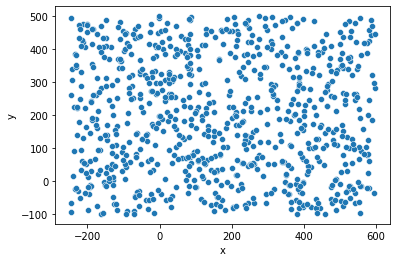

In [ ]:
min_x = 250
max_x = 600
min_y = 100
max_y = 500
samples = 800

x:np.ndarray = np.random.uniform(-min_x, max_x, samples)
y:np.ndarray = np.random.uniform(-min_y, max_y, samples)

df_u = pd.DataFrame(data={'x':x, 'y':y})

sns.scatterplot(data=df_u, x='x', y='y')
plt.show()

In [ ]:
mmscaler = MinMaxScaler()
normalized_matrix = mmscaler.fit_transform(df_u[['x', 'y']])

elbowl = ElbowLagrange(normalized_matrix, MIN_CLUSTERS, MAX_CLUSTERS)
print( "optimum-cluster:{}".format(elbowl.fit_transform()) )

optimum-cluster:5


Let's check the inertia of data

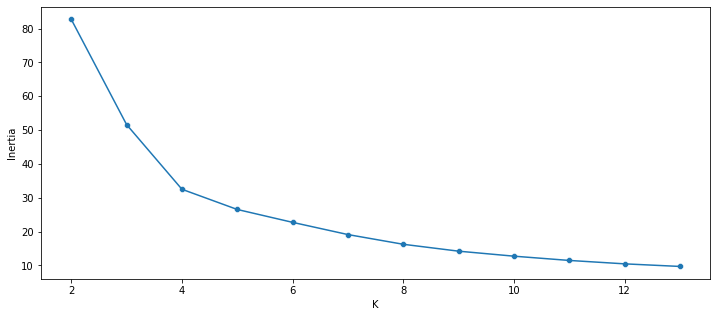

In [ ]:
MIN_CLUSTERS = 2
MAX_CLUSTERS = 13
k, inertia = generate_inertia(normalized_matrix, MIN_CLUSTERS, MAX_CLUSTERS)

plt.subplots(figsize=(12,5))
sns.lineplot(x=k, y=inertia)
sns.scatterplot(x=k, y=inertia)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

*Derivation and linearity*

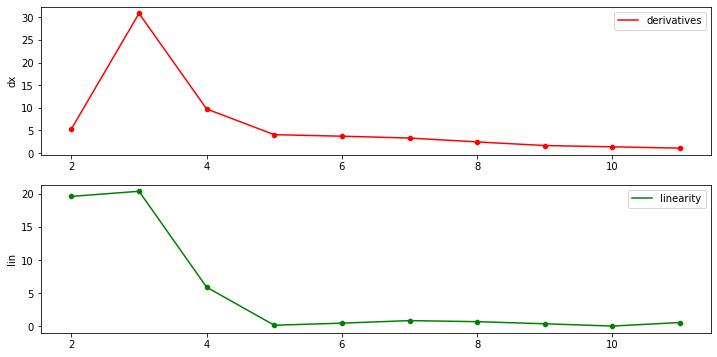

In [ ]:
y_dx  = elbowl.get_derivatives()[:-1]
y_lin = elbowl.get_linearity()

df_u = pd.DataFrame(data={'dx':y_dx,'lin':y_lin})
df_u.index = np.arange(MIN_CLUSTERS, df_u.shape[0]+MIN_CLUSTERS)

_, axs = plt.subplots(figsize=(12,6), nrows=2)
sns.lineplot(x=df_u.index, y=df_u['dx'], ax=axs[0], color='red', label='derivatives')
sns.scatterplot(x=df_u.index, y=df_u['dx'], ax=axs[0], color='red')
sns.lineplot(x=df_u.index, y=df_u['lin'], ax=axs[1], color='green', label='linearity')
sns.scatterplot(x=df_u.index, y=df_u['lin'], ax=axs[1], color='green')

plt.show()

In [ ]:
df_u

,dx,lin
2,5.323830,19.596272
3,30.859256,20.367256
4,9.733103,5.908728
5,4.061693,0.183097
6,3.723897,0.497293
7,3.316380,0.882352
8,2.460248,0.719006
9,1.657759,0.402948
10,1.381590,0.058393
11,1.081839,0.594948


# Elbow-Lagrange in Gaussian distribution

Let's repeat the same analysis on a Gaussian distribution

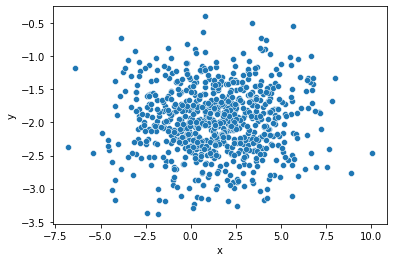

In [ ]:
samples = 750

x:np.ndarray = np.random.normal(1.5, 2.5, samples)
y:np.ndarray = np.random.normal(-2.0, 0.5, samples)

df_g = pd.DataFrame(data={'x':x, 'y':y})
mmscaler = MinMaxScaler()
normalized_matrix = mmscaler.fit_transform(df_g[['x', 'y']])

sns.scatterplot(data=df_g, x='x', y='y')
plt.show()

Let's look at the inertia plot of the Gaussian distribution

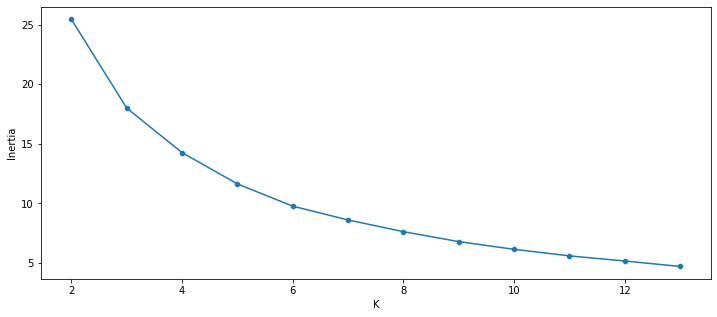

In [ ]:
MIN_CLUSTERS = 2
MAX_CLUSTERS = 13
k, inertia = generate_inertia(normalized_matrix, MIN_CLUSTERS, MAX_CLUSTERS)

plt.subplots(figsize=(12,5))
sns.lineplot(x=k, y=inertia)
sns.scatterplot(x=k, y=inertia)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

In [ ]:
elbowl = ElbowLagrange(normalized_matrix, MIN_CLUSTERS, MAX_CLUSTERS)
print( "optimum-cluster:{}".format(elbowl.fit_transform()) )

optimum-cluster:4


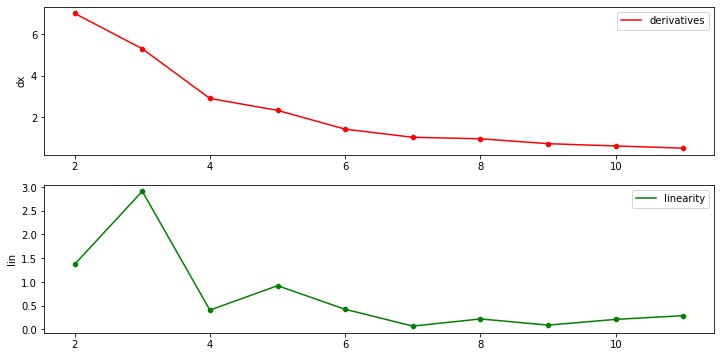

In [ ]:
y_dx  = elbowl.get_derivatives()[:-1]
y_lin = elbowl.get_linearity()

df_g = pd.DataFrame(data={'dx':y_dx,'lin':y_lin})
df_g.index = np.arange(MIN_CLUSTERS, df_g.shape[0]+MIN_CLUSTERS)

_, axs = plt.subplots(figsize=(12,6), nrows=2)

sns.lineplot(x=df_g.index, y=df_g['dx'], ax=axs[0], color='red', label='derivatives')
sns.scatterplot(x=df_g.index, y=df_g['dx'], ax=axs[0], color='red')
sns.lineplot(x=df_g.index, y=df_g['lin'], ax=axs[1], color='green', label='linearity')
sns.scatterplot(x=df_g.index, y=df_g['lin'], ax=axs[1], color='green')

plt.show()

In [ ]:
df_g

,dx,lin
2,7.010465,1.370942
3,5.298862,2.908698
4,2.897542,0.407341
5,2.321113,0.920842
6,1.412417,0.424423
7,1.018973,0.071246
8,0.947414,0.221101
9,0.710608,0.091385
10,0.600399,0.211864
11,0.493966,0.290599


Conclusion:

As we see, the method varies depending on the data. In these examples from a uniform and a Gaussian distribution. In a stage of further investigation I found that in some cases this technique gives partially incorrect results, which is logical, the method could be further refined since for the moment all we did was to use a single criterion around a point. In the last section we will improve this, and we will test it again!

# Robust Elbow-Lagrange

To make the method more robust we will use a column vector or list, in it we will put the total amount of minimum values (determined by a threshold) that we find, we will make this possible by calculating at each point the *forward linearity* of the total remaining in the list or vector determined in each iteration that we perform.

The concept is the following:

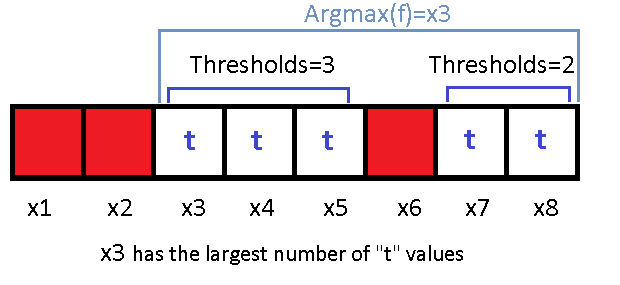

In other words, the threshold will determine if it is an acceptable value or not, and in each element of the list there will be a value calculated from a difference between derivatives (as explained above). Once we have obtained the linearized data we will search:

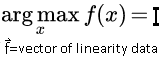

Where **I** represents the index or position of the array where the real value f(x) has the most linearized data from that position.

In [ ]:
class LagrangeInterpolation:
  def __init__(self, x:list, y:list):
    self.__x = x
    self.__y = y
    self.__n = len(x)
  
  def fit_transform(self, x:float):
    lx = 0.0
    for i in range(0, self.__n, 1):
        l_coeff = 1.0
        for j in range(0, self.__n, 1):
            if j != i:
                xj = self.__x[j]
                l_coeff = l_coeff * (x - xj)/(self.__x[i] - xj)
        
        lx += self.__y[i] * l_coeff
    
    return lx
  
  def dydx(self, x)->float:
    h = 1e-5 # in theory h is an infinitesimal
    return (self.fit_transform(x+h)-self.fit_transform(x))/h

class RobustElbowLagrange:
  def __init__(self, normalized_matrix, min_clusters:int=2, max_clusters:int=7)->None:
    self.__MIN_C = min_clusters
    self.__MAX_C = max_clusters
    self.__normalized_matrix = normalized_matrix
    self.__dydx_list = None
    self.threshold_dist = 1.0
  
  def __generate_inertia(self)->list:
    k_list  = list()
    inertia = list()

    for k in range(self.__MIN_C, self.__MAX_C+1):
      km = KMeans(n_clusters=k)
      km.fit(self.__normalized_matrix)

      k_list.append(k)
      inertia.append(km.inertia_)

    return k_list, inertia
  
  def __compute_derivatives(self, k:list, inertia:list)->list:
    lag = LagrangeInterpolation(k, inertia)
    # evitamos que la derivada se excede del intervalo
    k_ = k[:-1]
    dydx_= []
    for x in k_:
      dydx_.append( np.abs(lag.dydx(x)) )
    return dydx_

  def __compute_forward_linearity(self, k:list, inertia:list)->list:
    self.__dydx_list:list = self.__compute_derivatives(k, inertia)
    L:int = len(self.__dydx_list)-1
    z_list = list()
    for i in range(0, L):
      dist = np.abs(self.__dydx_list[i+1] - self.__dydx_list[i])
      z = 0
      if dist < self.threshold_dist:
        # empezamos encontrando como minimo una distancia
        z = 1
        for j in range(i+1,L):
          dist = np.abs(self.__dydx_list[j+1] - self.__dydx_list[j])
          if dist < self.threshold_dist:
            z+= 1
          else:
            break
      z_list.append(z)

    return z_list
  
  def get_derivatives(self)->list:
    return self.__dydx_list
  
  def get_linearity(self)->list:
    k, inertia = self.__generate_inertia()
    dydx = self.__compute_derivatives(k, inertia)

    dist_ = []
    for x in range(0, len(dydx)-1):
      dist_.append( np.abs(dydx[x+1] - dydx[x]) )
    return dist_

  def fit_transform(self)->int:
    self.k, self.inertia = self.__generate_inertia()
    lin_list:list = self.__compute_forward_linearity(k, inertia)
    return self.__MIN_C + np.argmax(lin_list)

---

let us once again generate another uniform distribution

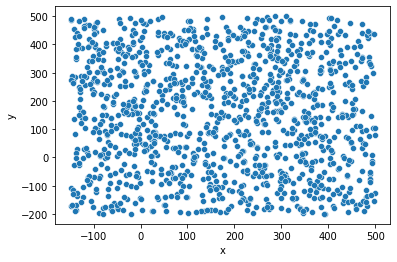

In [ ]:
min_x = 150
max_x = 500
min_y = 200
max_y = 500
samples = 1200

x:np.ndarray = np.random.uniform(-min_x, max_x, samples)
y:np.ndarray = np.random.uniform(-min_y, max_y, samples)

df_u = pd.DataFrame(data={'x':x, 'y':y})
mmscaler = MinMaxScaler()
normalized_matrix = mmscaler.fit_transform(df_u[['x', 'y']])

sns.scatterplot(data=df_u, x='x', y='y')
plt.show()

In [ ]:
relbowl = RobustElbowLagrange(normalized_matrix, MIN_CLUSTERS, MAX_CLUSTERS)
print( "optimum-cluster:{}".format(relbowl.fit_transform()) )

optimum-cluster:4


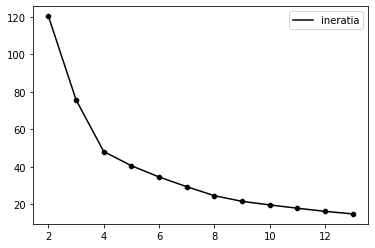

In [ ]:
sns.lineplot(x=relbowl.k, y=relbowl.inertia, color='black', label='ineratia')
sns.scatterplot(x=relbowl.k, y=relbowl.inertia, color='black')
plt.show()

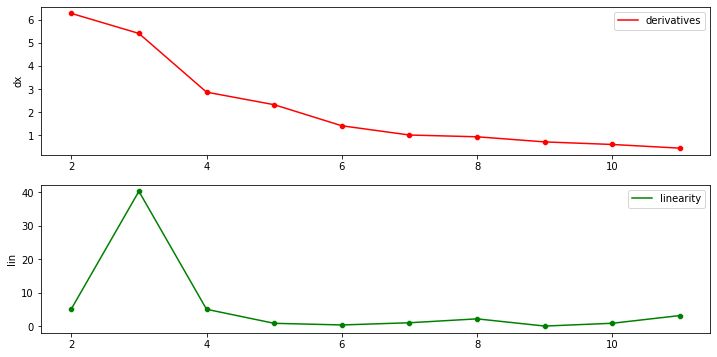

In [ ]:
y_dx  = relbowl.get_derivatives()[:-1]
y_lin = relbowl.get_linearity()

df_u = pd.DataFrame(data={'dx':y_dx,'lin':y_lin})
df_u.index = np.arange(MIN_CLUSTERS, df_g.shape[0]+MIN_CLUSTERS)

_, axs = plt.subplots(figsize=(12,6), nrows=2)

sns.lineplot(x=df_u.index, y=df_u['dx'], ax=axs[0], color='red', label='derivatives')
sns.scatterplot(x=df_u.index, y=df_u['dx'], ax=axs[0], color='red')
sns.lineplot(x=df_u.index, y=df_u['lin'], ax=axs[1], color='green', label='linearity')
sns.scatterplot(x=df_u.index, y=df_u['lin'], ax=axs[1], color='green')

plt.show()

In [ ]:
df_u

,dx,lin
2,6.268962,5.083499
3,5.402834,40.235168
4,2.866988,5.012442
5,2.324460,0.823440
6,1.414345,0.334013
7,1.014746,0.990696
8,0.939135,2.154428
9,0.717533,0.002842
10,0.606544,0.841111
11,0.447517,3.140178


--- 

let's generate once again another Gaussian distribution

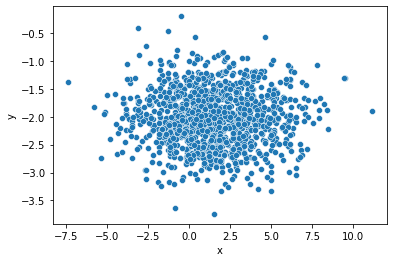

In [ ]:
samples = 1200

x:np.ndarray = np.random.normal(1.5, 2.5, samples)
y:np.ndarray = np.random.normal(-2.0, 0.5, samples)

df_g = pd.DataFrame(data={'x':x, 'y':y})

mmscaler = MinMaxScaler()
normalized_matrix = mmscaler.fit_transform(df_g[['x', 'y']])

sns.scatterplot(data=df_g, x='x', y='y')
plt.show()

In [ ]:
relbowl = RobustElbowLagrange(normalized_matrix, MIN_CLUSTERS, MAX_CLUSTERS)
print( "optimim cluster:{}".format(relbowl.fit_transform()) )

optimim cluster:4


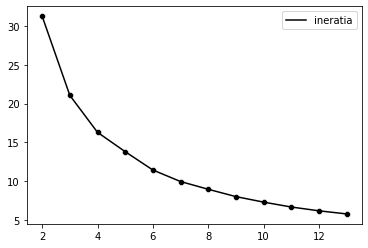

In [ ]:
sns.lineplot(x=relbowl.k, y=relbowl.inertia, color='black', label='ineratia')
sns.scatterplot(x=relbowl.k, y=relbowl.inertia, color='black')
plt.show()

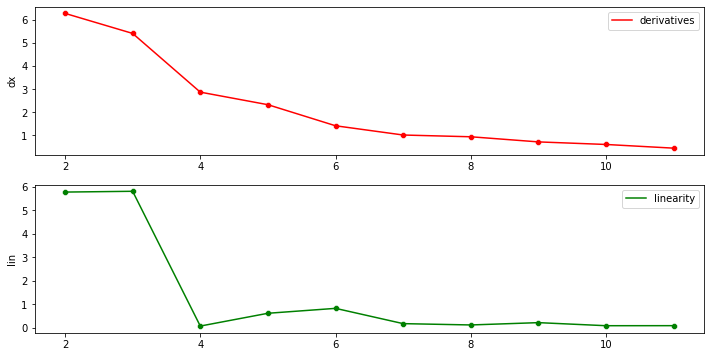

In [ ]:
y_dx  = relbowl.get_derivatives()[:-1]
y_lin = relbowl.get_linearity()

df_g = pd.DataFrame(data={'dx':y_dx,'lin':y_lin})
df_g.index = np.arange(MIN_CLUSTERS, df_g.shape[0]+MIN_CLUSTERS)

_, axs = plt.subplots(figsize=(12,6), nrows=2)

sns.lineplot(x=df_g.index, y=df_g['dx'], ax=axs[0], color='red', label='derivatives')
sns.scatterplot(x=df_g.index, y=df_g['dx'], ax=axs[0], color='red')
sns.lineplot(x=df_g.index, y=df_g['lin'], ax=axs[1], color='green', label='linearity')
sns.scatterplot(x=df_g.index, y=df_g['lin'], ax=axs[1], color='green')

plt.show()

In [ ]:
df_g

,dx,lin
2,6.268962,5.774560
3,5.402834,5.808165
4,2.866988,0.067681
5,2.324460,0.612279
6,1.414345,0.821652
7,1.014746,0.170882
8,0.939135,0.114804
9,0.717533,0.213274
10,0.606544,0.082624
11,0.447517,0.084491


Conclusion:

As we can see we explored a base concept from where my initial idea started, and from there we looked for a more robust method with which to obtain the value of the optimal cluster in a more accurate way. Of course we only tested two different types of distributions (uniform and normal), and although in the real world the process to be analyzed may have another underlying distribution, the ideas and formulas demonstrated should be sufficient to use this technique on any type of data(as long as KMeans allows it).

By the central limit theorem(CLT) we know that we can approximate any distribution (binomial, uniform, poisson, etc...) to a normal one. We can even apply mathematical transformations to normalize the data and arrive at a more trivial analysis.